In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Tuple
from sklearn.model_selection import train_test_split
import seaborn as sns

In [29]:
# ===============================================
# DATA GENERATION CLASS (for transparency)
# ===============================================
# This class shows how our training data was generated.
# The actual data used in this experiment is loaded from a pickle file below.

class AdjacencyMatrixGenerator:
    """
    A class to generate adjacency matrices for directed and undirected graphs.
    This code is included for transparency - actual data is loaded from pickle file.
    """
    
    def __init__(self):
        self.matrices = []
        self.labels = []
        
    def generate_symmetric_matrix(self, n: int) -> np.ndarray:
        """Generate a symmetric adjacency matrix (undirected graph)."""
        matrix = np.random.randint(0, 2, size=(n, n))
        matrix = np.triu(matrix) + np.triu(matrix, 1).T
        np.fill_diagonal(matrix, 0)
        return matrix
    
    def generate_non_symmetric_matrix(self, n: int) -> np.ndarray:
        """Generate a non-symmetric adjacency matrix (directed graph)."""
        matrix = np.random.randint(0, 2, size=(n, n))
        np.fill_diagonal(matrix, 0)
        if np.array_equal(matrix, matrix.T):
            for i in range(n):
                for j in range(i+1, n):
                    if matrix[i, j] == matrix[j, i]:
                        matrix[i, j] = 1 - matrix[i, j]
                        break
                else:
                    continue
                break
        return matrix
    
    def generate_dataset(self, n: int, num_symmetric: int, num_non_symmetric: int):
        """Generate a dataset of adjacency matrices."""
        self.matrices = []
        self.labels = []
        
        for _ in range(num_symmetric):
            matrix = self.generate_symmetric_matrix(n)
            self.matrices.append(matrix)
            self.labels.append(0)
            
        for _ in range(num_non_symmetric):
            matrix = self.generate_non_symmetric_matrix(n)
            self.matrices.append(matrix)
            self.labels.append(1)
    
    def save_to_pickle(self, filename: str):
        """Save the generated matrices and labels to a pickle file."""
        data = {
            'matrices': self.matrices,
            'labels': self.labels,
            'matrix_size': len(self.matrices[0]) if self.matrices else 0
        }
        
        with open(filename, 'wb') as f:
            pickle.dump(data, f)
        
        print(f"Saved {len(self.matrices)} matrices to {filename}")
    
    def load_from_pickle(self, filename: str):
        """Load matrices and labels from a pickle file."""
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        
        self.matrices = data['matrices']
        self.labels = data['labels']
        
        print(f"Loaded {len(self.matrices)} matrices from {filename}")
    
    def get_flattened_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Get matrices flattened into vectors for neural network input."""
        if not self.matrices:
            return np.array([]), np.array([])
        
        flattened_matrices = np.array([matrix.flatten() for matrix in self.matrices])
        labels_array = np.array(self.labels)
        
        return flattened_matrices, labels_array


In [30]:
# Neural Network class to classify graphs
class NeuralNetwork:
    @staticmethod
    def sigmoid(x):
        """Sigmoid activation function to map values to (0, 1)"""
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative_from_output(x):
        """Derivative of sigmoid for backpropagation"""
        return x * (1 - x)
    
    def __init__(self, input_size, hidden_size, output_size):
        # Use He initialization for better initial performance
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        
        # Add momentum for smoother training
        self.momentum = 0.9
        self.v_W1 = np.zeros_like(self.W1)
        self.v_b1 = np.zeros_like(self.b1)
        self.v_W2 = np.zeros_like(self.W2)
        self.v_b2 = np.zeros_like(self.b2)
    
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def backward(self, X, y, output, learning_rate, weight_decay):
        self.error = y - output
        self.delta2 = self.error * self.sigmoid_derivative_from_output(output)
        self.error_hidden = np.dot(self.delta2, self.W2.T)
        self.delta1 = self.error_hidden * self.sigmoid_derivative_from_output(self.a1)

        # More efficient momentum updates
        self.v_W2 = self.momentum * self.v_W2 + learning_rate * (np.dot(self.a1.T, self.delta2) - weight_decay * self.W2)
        self.v_b2 = self.momentum * self.v_b2 + learning_rate * np.sum(self.delta2, axis=0, keepdims=True)
        self.v_W1 = self.momentum * self.v_W1 + learning_rate * (np.dot(X.T, self.delta1) - weight_decay * self.W1)
        self.v_b1 = self.momentum * self.v_b1 + learning_rate * np.sum(self.delta1, axis=0, keepdims=True)
        
        # Update weights
        self.W2 += self.v_W2
        self.b2 += self.v_b2
        self.W1 += self.v_W1
        self.b1 += self.v_b1

    def train(self, X, y, X_val, y_val, epochs, learning_rate, weight_decay, patience=1000):
        errors = []
        val_errors = []
        best_error = float('inf')
        patience_counter = 0
        
        print(f"Training: {epochs} epochs max, LR: {learning_rate}, WD: {weight_decay}")
        print("Epoch | Train MSE | Val MSE | Gap | Status")
        print("-" * 45)
        
        for epoch in range(epochs):
            # Forward and backward pass
            output = self.forward(X)
            self.backward(X, y, output, learning_rate, weight_decay)
            mse = np.mean(np.square(y - output))
            errors.append(mse)
            
            # Calculate validation error
            val_output = self.forward(X_val)
            val_mse = np.mean(np.square(y_val - val_output))
            val_errors.append(val_mse)
            
            # Early stopping logic (use validation error)
            if val_mse < best_error:
                best_error = val_mse
                patience_counter = 0
                status = "↘️"
            else:
                patience_counter += 1
                status = "→"
                
            if patience_counter >= patience:
                print(f"{epoch:5d} | {mse:.6f} | {val_mse:.6f} | {val_mse-mse:.6f} | Early Stop!")
                break
            
            # Progress every 1000 epochs (less verbose)
            if epoch % 1000 == 0:
                gap = val_mse - mse
                print(f"{epoch:5d} | {mse:.6f} | {val_mse:.6f} | {gap:.6f} | {status}")
        
        print(f"Final - Train MSE: {errors[-1]:.6f}, Val MSE: {val_errors[-1]:.6f}")
        return errors, val_errors

def plot_learning_curves(train_errors, val_errors, save_path=None, show_accuracy=True):
    """Plot learning curves to analyze training behavior."""
    if show_accuracy:
        # Convert errors to accuracies (assuming binary classification)
        # For MSE, lower error = higher accuracy
        max_error = max(max(train_errors), max(val_errors))
        train_accuracies = [(max_error - err) / max_error for err in train_errors]
        val_accuracies = [(max_error - err) / max_error for err in val_errors]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        epochs = range(len(train_errors))
        
        # Plot 1: Training vs Validation Accuracy (familiar format)
        ax1.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
        ax1.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Learning Curves: Training vs Validation Accuracy')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 1)
        
        # Highlight overfitting region
        if len(train_accuracies) > 1000:
            # Find where validation accuracy starts decreasing while training continues increasing
            val_decreasing = False
            overfitting_start = None
            for i in range(1000, len(val_accuracies)-1):
                if val_accuracies[i] < val_accuracies[i-1] and train_accuracies[i] > train_accuracies[i-1]:
                    if not val_decreasing:
                        overfitting_start = i
                        val_decreasing = True
                elif val_accuracies[i] > val_accuracies[i-1]:
                    val_decreasing = False
            
            if overfitting_start:
                ax1.axvline(x=overfitting_start, color='orange', linestyle='--', 
                           alpha=0.7, label=f'Overfitting starts ~epoch {overfitting_start}')
                ax1.legend()
        
        # Plot 2: Accuracy Gap Analysis
        gaps = [train_accuracies[i] - val_accuracies[i] for i in range(len(train_accuracies))]
        ax2.plot(epochs, gaps, 'g-', linewidth=2, alpha=0.8)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Training Accuracy - Validation Accuracy')
        ax2.set_title('Accuracy Gap Analysis (Overfitting Indicator)')
        ax2.grid(True, alpha=0.3)
        
        # Add threshold line for overfitting
        threshold = 0.05  # 5% accuracy gap threshold for overfitting
        ax2.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                   label=f'Overfitting threshold ({threshold:.0%})')
        ax2.legend()
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print analysis
        print("\n=== LEARNING CURVE ANALYSIS (Accuracy) ===")
        print(f"Initial training accuracy: {train_accuracies[0]:.2%}")
        print(f"Final training accuracy: {train_accuracies[-1]:.2%}")
        print(f"Initial validation accuracy: {val_accuracies[0]:.2%}")
        print(f"Final validation accuracy: {val_accuracies[-1]:.2%}")
        
        final_gap = train_accuracies[-1] - val_accuracies[-1]
        print(f"Final accuracy gap: {final_gap:.2%}")
        
        if final_gap > 0.05:
            print("⚠️  Significant overfitting detected (gap > 5%)")
        elif final_gap < 0.01:
            print("✅ Good generalization (small gap)")
        else:
            print("⚠️  Moderate overfitting (gap between 1-5%)")
        
        # Find optimal stopping point (maximum validation accuracy)
        max_val_epoch = np.argmax(val_accuracies)
        print(f"Optimal stopping point: epoch {max_val_epoch} (val accuracy: {val_accuracies[max_val_epoch]:.2%})")
        
        if max_val_epoch < len(val_accuracies) - 100:
            print(f"💡 Could have stopped {len(val_accuracies) - max_val_epoch} epochs earlier!")
        
        return max_val_epoch
    
    else:
        # Original error-based curves
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        epochs = range(len(train_errors))
        
        # Plot 1: Training vs Validation Error
        ax1.plot(epochs, train_errors, 'b-', label='Training Error', linewidth=2, alpha=0.8)
        ax1.plot(epochs, val_errors, 'r-', label='Validation Error', linewidth=2, alpha=0.8)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Mean Squared Error')
        ax1.set_title('Learning Curves: Training vs Validation Error')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')
        
        # Highlight overfitting region
        if len(train_errors) > 1000:
            # Find where validation error starts increasing while training continues decreasing
            val_increasing = False
            overfitting_start = None
            for i in range(1000, len(val_errors)-1):
                if val_errors[i] > val_errors[i-1] and train_errors[i] < train_errors[i-1]:
                    if not val_increasing:
                        overfitting_start = i
                        val_increasing = True
                elif val_errors[i] < val_errors[i-1]:
                    val_increasing = False
            
            if overfitting_start:
                ax1.axvline(x=overfitting_start, color='orange', linestyle='--', 
                           alpha=0.7, label=f'Overfitting starts ~epoch {overfitting_start}')
                ax1.legend()
        
        # Plot 2: Error Gap Analysis
        gaps = [val_errors[i] - train_errors[i] for i in range(len(train_errors))]
        ax2.plot(epochs, gaps, 'g-', linewidth=2, alpha=0.8)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Validation Error - Training Error')
        ax2.set_title('Error Gap Analysis (Overfitting Indicator)')
        ax2.grid(True, alpha=0.3)
        
        # Add threshold line for overfitting
        threshold = 0.01  # Gap threshold for overfitting
        ax2.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                   label=f'Overfitting threshold ({threshold})')
        ax2.legend()
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Print analysis
        print("\n=== LEARNING CURVE ANALYSIS (Error) ===")
        print(f"Initial training error: {train_errors[0]:.6f}")
        print(f"Final training error: {train_errors[-1]:.6f}")
        print(f"Initial validation error: {val_errors[0]:.6f}")
        print(f"Final validation error: {val_errors[-1]:.6f}")
        
        final_gap = val_errors[-1] - train_errors[-1]
        print(f"Final error gap: {final_gap:.6f}")
        
        if final_gap > 0.01:
            print("⚠️  Significant overfitting detected (gap > 0.01)")
        elif final_gap < 0.001:
            print("✅ Good generalization (small gap)")
        else:
            print("⚠️  Moderate overfitting (gap between 0.001-0.01)")
        
        # Find optimal stopping point (minimum validation error)
        min_val_epoch = np.argmin(val_errors)
        print(f"Optimal stopping point: epoch {min_val_epoch} (val error: {val_errors[min_val_epoch]:.6f})")
        
        if min_val_epoch < len(val_errors) - 100:
            print(f"💡 Could have stopped {len(val_errors) - min_val_epoch} epochs earlier!")
        
        return min_val_epoch


In [31]:
def plot_comprehensive_learning_curves(train_errors, val_errors, nn, X_train, y_train, X_val, y_val, 
                                      learning_rates=[0.001, 0.01, 0.1, 0.5], 
                                      hidden_sizes=None, save_path=None):
    """Plot comprehensive learning curves showing all aspects of training."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Comprehensive Learning Curve Analysis', fontsize=16, fontweight='bold')
    
    epochs = range(len(train_errors))
    
    # ===============================================
    # 1. ACCURACY CURVES (Top Left)
    # ===============================================
    max_error = max(max(train_errors), max(val_errors))
    train_accuracies = [(max_error - err) / max_error for err in train_errors]
    val_accuracies = [(max_error - err) / max_error for err in val_errors]
    
    ax1.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2, alpha=0.8)
    ax1.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('1. Training vs Validation Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Highlight overfitting
    if len(train_accuracies) > 1000:
        val_decreasing = False
        overfitting_start = None
        for i in range(1000, len(val_accuracies)-1):
            if val_accuracies[i] < val_accuracies[i-1] and train_accuracies[i] > train_accuracies[i-1]:
                if not val_decreasing:
                    overfitting_start = i
                    val_decreasing = True
            elif val_accuracies[i] > val_accuracies[i-1]:
                val_decreasing = False
        
        if overfitting_start:
            ax1.axvline(x=overfitting_start, color='orange', linestyle='--', 
                       alpha=0.7, label=f'Overfitting starts ~epoch {overfitting_start}')
            ax1.legend()
    
    # ===============================================
    # 2. ERROR CURVES (Top Right)
    # ===============================================
    ax2.plot(epochs, train_errors, 'b-', label='Training Error', linewidth=2, alpha=0.8)
    ax2.plot(epochs, val_errors, 'r-', label='Validation Error', linewidth=2, alpha=0.8)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.set_title('2. Training vs Validation Error')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Add accuracy gap analysis
    gaps = [train_accuracies[i] - val_accuracies[i] for i in range(len(train_accuracies))]
    ax2_twin = ax2.twinx()
    ax2_twin.plot(epochs, gaps, 'g--', label='Accuracy Gap', linewidth=1, alpha=0.6)
    ax2_twin.set_ylabel('Accuracy Gap', color='g')
    ax2_twin.tick_params(axis='y', labelcolor='g')
    ax2_twin.axhline(y=0.05, color='orange', linestyle=':', alpha=0.7, label='Overfitting threshold')
    ax2_twin.legend(loc='upper right')
    
    # ===============================================
    # 3. LEARNING RATE SENSITIVITY (Bottom Left)
    # ===============================================
    lr_results = []
    current_weights = {
        'W1': nn.W1.copy(), 'W2': nn.W2.copy(),
        'b1': nn.b1.copy(), 'b2': nn.b2.copy()
    }
    
    # More conservative learning rate range around current LR
    current_lr = learning_rate  # Use actual current LR from profile
    learning_rates = [
        current_lr * 0.1,    # 10x smaller
        current_lr * 0.5,    # 2x smaller  
        current_lr,          # current
        current_lr * 2,      # 2x larger
        current_lr * 5,      # 5x larger
        current_lr * 10      # 10x larger
    ]
    
    for lr in learning_rates:
        # Reset to current best weights
        nn.W1 = current_weights['W1'].copy()
        nn.W2 = current_weights['W2'].copy()
        nn.b1 = current_weights['b1'].copy()
        nn.b2 = current_weights['b2'].copy()
        
        # Train for a few epochs with this learning rate
        test_errors = []
        val_errors_lr = []
        
        for epoch in range(100):  # Shorter test to avoid dramatic changes
            output = nn.forward(X_train)
            nn.backward(X_train, y_train, output, lr, weight_decay)
            mse = np.mean(np.square(y_train - output))
            test_errors.append(mse)
            
            # Also check validation error
            val_output = nn.forward(X_val)
            val_mse = np.mean(np.square(y_val - val_output))
            val_errors_lr.append(val_mse)
        
        # Use validation error for better assessment
        lr_results.append((lr, val_errors_lr[-1], test_errors[-1]))
    
    lrs, final_val_errors, final_train_errors = zip(*lr_results)
    ax3.semilogx(lrs, final_val_errors, 'bo-', linewidth=2, markersize=8, label='Validation Error')
    ax3.set_xlabel('Learning Rate')
    ax3.set_ylabel('Final Validation Error')
    ax3.set_title('3. Learning Rate Sensitivity')
    ax3.grid(True, alpha=0.3)
    
    # Highlight current learning rate
    ax3.axvline(x=current_lr, color='red', linestyle='--', alpha=0.7, 
               label=f'Current LR: {current_lr}')
    ax3.legend()
    
    # ===============================================
    # 4. MODEL CAPACITY ANALYSIS (Bottom Right)
    # ===============================================
    capacity_results = []
    original_hidden_size = nn.W1.shape[0]
    actual_input_size = X_train.shape[1]
    current_size = original_hidden_size  # Define current_size here
    
    # Use relative hidden sizes based on current capacity
    if hidden_sizes is None:
        # Create relative sizes based on current hidden size
        hidden_sizes = [
            max(2, current_size // 4),      # 1/4 of current size
            max(4, current_size // 2),      # 1/2 of current size
            current_size,                   # current size
            current_size * 2,               # 2x current size
            current_size * 4,               # 4x current size
            current_size * 8                # 8x current size
        ]
    
    # Ensure current size is included and sort the list
    if current_size not in hidden_sizes:
        hidden_sizes.append(current_size)
    hidden_sizes = sorted(list(set(hidden_sizes)))  # Remove duplicates and sort
    
    print(f"Testing capacity sizes: {hidden_sizes}")
    
    for hidden_size in hidden_sizes:
        # Create new network with different capacity
        temp_nn = NeuralNetwork(input_size=actual_input_size, hidden_size=hidden_size, output_size=1)
        
        # Train for more epochs for better assessment
        temp_train_errors = []
        temp_val_errors = []
        
        for epoch in range(300):  # Longer training for capacity analysis
            output = temp_nn.forward(X_train)
            temp_nn.backward(X_train, y_train, output, learning_rate, weight_decay)
            train_mse = np.mean(np.square(y_train - output))
            temp_train_errors.append(train_mse)
            
            # Check validation error
            val_output = temp_nn.forward(X_val)
            val_mse = np.mean(np.square(y_val - val_output))
            temp_val_errors.append(val_mse)
        
        capacity_results.append((hidden_size, temp_val_errors[-1], temp_train_errors[-1]))
    
    hidden_sizes_list, final_val_errors_cap, final_train_errors_cap = zip(*capacity_results)
    
    # Plot both training and validation errors
    ax4.plot(hidden_sizes_list, final_val_errors_cap, 'go-', linewidth=2, markersize=8, label='Validation Error')
    ax4.plot(hidden_sizes_list, final_train_errors_cap, 'bo-', linewidth=2, markersize=6, alpha=0.7, label='Training Error')
    ax4.set_xlabel('Hidden Layer Size')
    ax4.set_ylabel('Final Error')
    ax4.set_title('4. Model Capacity Analysis')
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')  # Use log scale to better see differences
    
    # Highlight current hidden size with a more prominent marker
    current_idx = hidden_sizes_list.index(current_size) if current_size in hidden_sizes_list else None
    if current_idx is not None:
        ax4.plot(current_size, final_val_errors_cap[current_idx], 'ro', markersize=12, 
                markeredgecolor='black', markeredgewidth=2, label=f'Current Size: {current_size}')
    
    # Add a vertical line for current size
    ax4.axvline(x=current_size, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    ax4.legend()
    
    # Set x-axis limits to show a reasonable range around current size
    min_size = min(hidden_sizes_list)
    max_size = max(hidden_sizes_list)
    ax4.set_xlim(min_size * 0.8, max_size * 1.2)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    

In [32]:
# ===============================================
# PROFILE SYSTEM FOR DIFFERENT MATRIX SIZES
# ===============================================
# Choose your profile by setting the profile name
# Each profile has optimized parameters for its matrix size

PROFILES = {
    "4x4": {
        "matrix_size": 4,
        "hidden_size": 8,  # Reduced for efficiency
        "learning_rate": 0.0005,  # Reduced from 0.001 to prevent overflow
        "weight_decay": 0.02,  # Increased from 0.01 for better regularization
        "epochs": 10000,
        "num_samples": 6000,
        "data_file": "neural_network_training_data_4x4.pkl",
        "description": "Small matrices"
    },
    "5x5": {
        "matrix_size": 5,
        "hidden_size": 6,  # Middle ground between 4 and 8
        "learning_rate": 0.001,  # Constant, no scheduling
        "weight_decay": 0.02,  # Moderate regularization (between 0.01 and 0.05)
        "epochs": 15000,  # Reduced since we have early stopping
        "num_samples": 8000,
        "data_file": "neural_network_training_data_5x5.pkl",
        "description": "Medium matrices"
    },
    "6x6": {
        "matrix_size": 6,
        "hidden_size": 56,  # Reduced from 56 to reduce oscillations
        "learning_rate": 0.001,  # Reduced from 0.001 for more stable training
        "weight_decay": 0.01,  # Increased from 0.01 for better regularization
        "epochs": 7000,
        "num_samples": 8000,
        "data_file": "neural_network_training_data_6x6.pkl",
        "description": "Large matrices"
    }
}

def show_available_profiles():
    """Display all available profiles and their status"""
    print("📋 Available Profiles:")
    print("=" * 60)
    for name, config in PROFILES.items():
        import os
        data_exists = os.path.exists(config["data_file"])
        status = "✅ Data ready" if data_exists else "❌ No data"
        print(f"🎯 {name}: {config['description']}")
        print(f"   📊 {config['matrix_size']}x{config['matrix_size']} matrices")
        print(f"   🧠 Hidden size: {config['hidden_size']}")
        print(f"   📈 LR: {config['learning_rate']}, WD: {config['weight_decay']}")
        print(f"   🔄 Epochs: {config['epochs']}, Samples: {config['num_samples']}")
        print(f"   💾 {config['data_file']} - {status}")
        print()

# Uncomment the line below to see all available profiles
# show_available_profiles()

# ===============================================
# SELECT YOUR PROFILE HERE
# ===============================================
# Change this line to switch between profiles
SELECTED_PROFILE = "6x6"  # Options: "4x4", "5x5", "6x6"

# Load the selected profile
if SELECTED_PROFILE not in PROFILES:
    print(f"❌ Profile '{SELECTED_PROFILE}' not found. Available profiles: {list(PROFILES.keys())}")
    exit(1)

profile = PROFILES[SELECTED_PROFILE]
matrix_size = profile["matrix_size"]
hidden_size = profile["hidden_size"]
learning_rate = profile["learning_rate"]
weight_decay = profile["weight_decay"]
epochs = profile["epochs"]
num_samples = profile["num_samples"]
data_file = profile["data_file"]

input_size = matrix_size * matrix_size
output_size = 1

print(f"🎯 Using Profile: {SELECTED_PROFILE}")
print(f"📊 Matrix size: {matrix_size}x{matrix_size} ({input_size} features)")
print(f"🧠 Hidden layer size: {hidden_size}")
print(f"📈 Learning rate: {learning_rate}")
print(f"⚖️  Weight decay: {weight_decay}")
print(f"🔄 Epochs: {epochs}")
print(f"📦 Samples: {num_samples}")
print(f"💾 Data file: {data_file}")
print("-" * 50)

🎯 Using Profile: 6x6
📊 Matrix size: 6x6 (36 features)
🧠 Hidden layer size: 56
📈 Learning rate: 0.001
⚖️  Weight decay: 0.01
🔄 Epochs: 7000
📦 Samples: 8000
💾 Data file: neural_network_training_data_6x6.pkl
--------------------------------------------------


In [33]:
# ===============================================
# LOAD TRAINING DATA
# ===============================================
# Load data using our class methods
generator = AdjacencyMatrixGenerator()

# Option 1: Load from pickle file (recommended for reproducibility)
try:
    generator.load_from_pickle(data_file)
    print("Using pre-generated dataset for reproducible results")
    
    # Check if the loaded data matches our expected matrix size
    if generator.matrices and len(generator.matrices[0]) != matrix_size:
        print(f"⚠️  Loaded data has {len(generator.matrices[0])}x{len(generator.matrices[0])} matrices, but expected {matrix_size}x{matrix_size}")
        print("Regenerating dataset with correct matrix size...")
        generator.generate_dataset(n=matrix_size, num_symmetric=num_samples//2, num_non_symmetric=num_samples//2)
        generator.save_to_pickle(data_file)
        print(f"✅ Generated new {matrix_size}x{matrix_size} dataset")
        
except FileNotFoundError:
    print("Pickle file not found. Generating new dataset...")
    generator.generate_dataset(n=matrix_size, num_symmetric=num_samples//2, num_non_symmetric=num_samples//2)
    generator.save_to_pickle(data_file)

# Get data ready for neural network
X, y = generator.get_flattened_data()
y = y.reshape(-1, 1)  # Reshape for neural network compatibility

print(f"Dataset ready: {len(X)} samples, {X.shape[1]} features each")

Loaded 8000 matrices from neural_network_training_data_6x6.pkl
Using pre-generated dataset for reproducible results
Dataset ready: 8000 samples, 36 features each


In [35]:
# ===============================================
# TRAIN/VALIDATION/TEST SPLIT
# ===============================================
# Split the data: 60% training, 20% validation, 20% testing
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 60% train, 20% validation (of original data)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 80% = 20% of original
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Verify the splits maintain class balance
train_zeros = np.sum(y_train == 0)
train_ones = np.sum(y_train == 1)
val_zeros = np.sum(y_val == 0)
val_ones = np.sum(y_val == 1)
test_zeros = np.sum(y_test == 0)
test_ones = np.sum(y_test == 1)

print(f"Training - Undirected: {train_zeros}, Directed: {train_ones}")
print(f"Validation - Undirected: {val_zeros}, Directed: {val_ones}")
print(f"Test - Undirected: {test_zeros}, Directed: {test_ones}")


Training set: 4800 samples
Validation set: 1600 samples
Test set: 1600 samples
Training - Undirected: 2400, Directed: 2400
Validation - Undirected: 800, Directed: 800
Test - Undirected: 800, Directed: 800


In [36]:
# ===============================================
# IMPROVED METRICS FUNCTIONS
# ===============================================
def calculate_metrics(y_true, y_pred_proba, threshold=0.5):
    """Calculate comprehensive classification metrics."""
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Basic metrics
    accuracy = np.mean(y_pred == y_true)
    
    # Confusion matrix components
    tp = np.sum((y_pred == 1) & (y_true == 1))  # True positives
    tn = np.sum((y_pred == 0) & (y_true == 0))  # True negatives
    fp = np.sum((y_pred == 1) & (y_true == 0))  # False positives
    fn = np.sum((y_pred == 0) & (y_true == 1))  # False negatives
    
    # Advanced metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # MSE
    mse = np.mean(np.square(y_pred_proba - y_true))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mse': mse,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

def plot_confusion_matrix(metrics, dataset_name="", save_path=None):
    """Create a visual confusion matrix plot."""
    # Extract values from metrics
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']
    
    # Create confusion matrix array
    cm = np.array([[tn, fp], [fn, tp]])
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted Undirected', 'Predicted Directed'],
                yticklabels=['Actual Undirected', 'Actual Directed'],
                ax=ax, cbar_kws={'label': 'Count'})
    
    # Add title and labels
    ax.set_title(f'Confusion Matrix - {dataset_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('Actual Label', fontsize=12)
    
    # Add performance metrics as text
    accuracy = metrics['accuracy']
    precision = metrics['precision']
    recall = metrics['recall']
    f1_score = metrics['f1_score']
    
    # Position text in the top right corner
    textstr = f'Accuracy: {accuracy:.2%}\nPrecision: {precision:.2%}\nRecall: {recall:.2%}\nF1-Score: {f1_score:.2%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return fig

def print_confusion_matrix(metrics, dataset_name=""):
    """Print a formatted confusion matrix."""
    print(f"\n=== {dataset_name.upper()} CONFUSION MATRIX ===")
    print(f"                Predicted")
    print(f"Actual  Undirected  Directed")
    print(f"Undirected    {metrics['tn']:4d}      {metrics['fp']:4d}")
    print(f"Directed      {metrics['fn']:4d}      {metrics['tp']:4d}")
    print(f"Total: {metrics['tn'] + metrics['fp'] + metrics['fn'] + metrics['tp']}")

def print_detailed_metrics(metrics, dataset_name=""):
    """Print comprehensive metrics."""
    print(f"\n=== {dataset_name.upper()} METRICS ===")
    print(f"Accuracy:  {metrics['accuracy']:.2%}")
    print(f"Precision: {metrics['precision']:.2%}")
    print(f"Recall:    {metrics['recall']:.2%}")
    print(f"F1-Score:  {metrics['f1_score']:.2%}")
    print(f"MSE:       {metrics['mse']:.6f}")

In [37]:
# ===============================================
# EFFICIENT TRAINING WITH VALIDATION MONITORING
# ===============================================
# Initialize the neural network with specified architecture
nn = NeuralNetwork(input_size, hidden_size, output_size)

# Train the network with validation monitoring
print("Starting efficient training with validation monitoring...")
train_errors, val_errors = nn.train(X_train, y_train, X_val, y_val, epochs, learning_rate, weight_decay, patience=1000)

Starting efficient training with validation monitoring...
Training: 7000 epochs max, LR: 0.001, WD: 0.01
Epoch | Train MSE | Val MSE | Gap | Status
---------------------------------------------
    0 | 0.260522 | 0.343330 | 0.082808 | ↘️
 1000 | 0.000387 | 0.003463 | 0.003076 | ↘️
 2000 | 0.000265 | 0.003153 | 0.002888 | ↘️
 3000 | 0.000243 | 0.003021 | 0.002778 | ↘️
 4000 | 0.000236 | 0.002908 | 0.002671 | ↘️
 5000 | 0.000232 | 0.002796 | 0.002563 | ↘️
 6000 | 0.000229 | 0.002690 | 0.002461 | ↘️
Final - Train MSE: 0.000227, Val MSE: 0.002596


In [38]:
# ===============================================
# VALIDATION EVALUATION
# ===============================================
print("\n=== VALIDATION EVALUATION ===")
val_predictions = []
for i in range(len(X_val)):
    pred = nn.forward(X_val[i:i+1])[0][0]
    val_predictions.append(pred)

val_predictions = np.array(val_predictions)
val_metrics = calculate_metrics(y_val.flatten(), val_predictions)
print_detailed_metrics(val_metrics, "Validation")


=== VALIDATION EVALUATION ===

=== VALIDATION METRICS ===
Accuracy:  99.62%
Precision: 100.00%
Recall:    99.25%
F1-Score:  99.62%
MSE:       0.002596


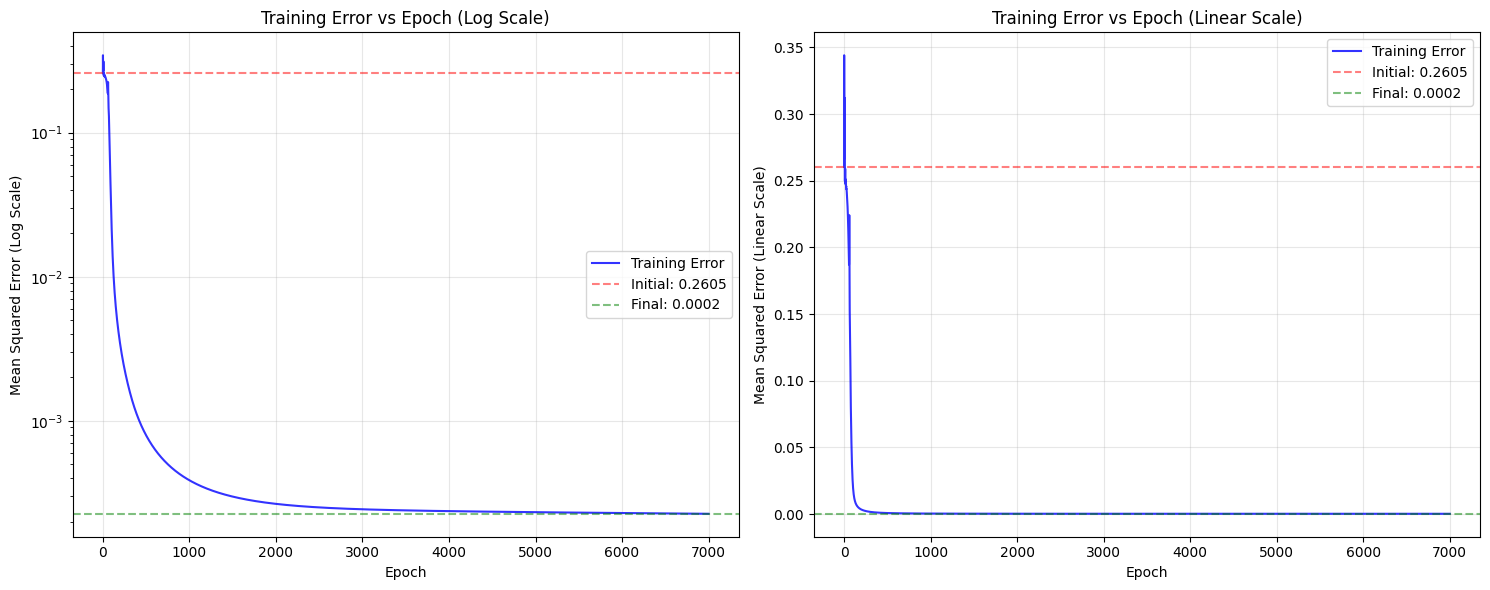


=== SCALING ANALYSIS ===
Initial error: 0.260522
Final error: 0.000227
Error reduction: 99.91%
✅ Log scale recommended (error reduced by 1150.1x)


In [39]:
# ===============================================
# SIMPLIFIED VISUALIZATION
# ===============================================
# Create a comprehensive training analysis plot with multiple scaling options
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Training error over time (Log scale - better for seeing convergence)
ax1.plot(train_errors, 'b-', alpha=0.8, linewidth=1.5, label='Training Error')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error (Log Scale)')
ax1.set_title('Training Error vs Epoch (Log Scale)')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')
ax1.legend()

# Add horizontal lines for reference
initial_error = train_errors[0]
final_error = train_errors[-1]
ax1.axhline(y=initial_error, color='red', linestyle='--', alpha=0.5, label=f'Initial: {initial_error:.4f}')
ax1.axhline(y=final_error, color='green', linestyle='--', alpha=0.5, label=f'Final: {final_error:.4f}')
ax1.legend()

# 2. Training error over time (Linear scale - better for seeing absolute values)
ax2.plot(train_errors, 'b-', alpha=0.8, linewidth=1.5, label='Training Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Squared Error (Linear Scale)')
ax2.set_title('Training Error vs Epoch (Linear Scale)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Add horizontal lines for reference
ax2.axhline(y=initial_error, color='red', linestyle='--', alpha=0.5, label=f'Initial: {initial_error:.4f}')
ax2.axhline(y=final_error, color='green', linestyle='--', alpha=0.5, label=f'Final: {final_error:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# Print scaling analysis
print("\n=== SCALING ANALYSIS ===")
print(f"Initial error: {initial_error:.6f}")
print(f"Final error: {final_error:.6f}")
print(f"Error reduction: {((initial_error - final_error) / initial_error * 100):.2f}%")

# Check if log scale is helpful
error_range = initial_error / final_error
if error_range > 10:
    print(f"✅ Log scale recommended (error reduced by {error_range:.1f}x)")
else:
    print(f"ℹ️  Linear scale sufficient (error reduced by {error_range:.1f}x)")


In [40]:
# ===============================================
# EFFICIENCY ANALYSIS
# ===============================================
print("\n=== EFFICIENCY ANALYSIS ===")
print(f"Total epochs trained: {len(train_errors)}")
print(f"Initial error: {train_errors[0]:.6f}")
print(f"Final error: {train_errors[-1]:.6f}")
print(f"Error reduction: {((train_errors[0] - train_errors[-1]) / train_errors[0] * 100):.2f}%")

# Check convergence
final_errors = train_errors[-100:] if len(train_errors) >= 100 else train_errors
error_std = np.std(final_errors)
print(f"Final 100 epochs std: {error_std:.6f}")

if error_std < 0.001:
    print("✅ Training converged efficiently")
else:
    print("⚠️  Training may need more epochs or parameter tuning")


=== EFFICIENCY ANALYSIS ===
Total epochs trained: 7000
Initial error: 0.260522
Final error: 0.000227
Error reduction: 99.91%
Final 100 epochs std: 0.000000
✅ Training converged efficiently



=== TEST EVALUATION ===

=== TEST METRICS ===
Accuracy:  99.62%
Precision: 100.00%
Recall:    99.25%
F1-Score:  99.62%
MSE:       0.002654


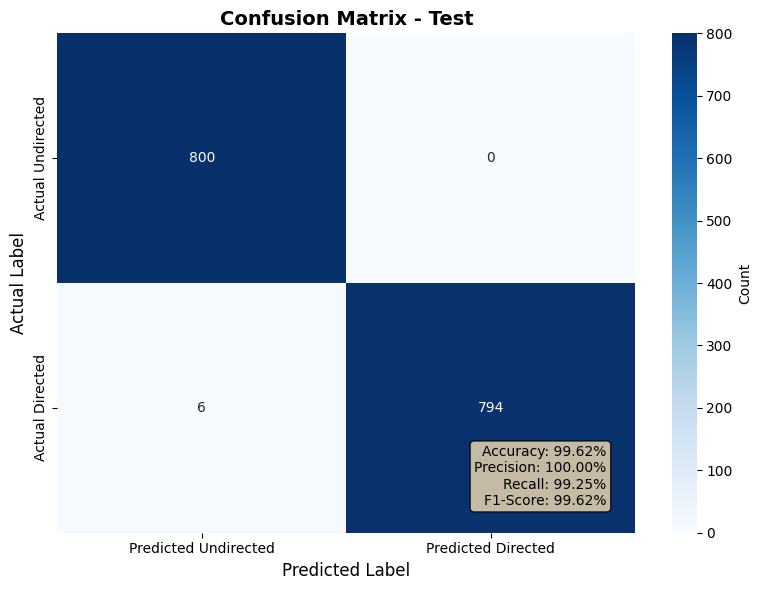


=== PERFORMANCE COMPARISON ===
Training MSE (final): 0.000227
Validation MSE: 0.002596
Test MSE: 0.002654
Validation/Training MSE ratio: 11.46
Test/Training MSE ratio: 11.72
⚠️  Test error significantly higher than training error - possible overfitting

=== SAMPLE PREDICTIONS ===
Sample 1: Predicted: 0.995 (Directed), Actual: Directed
Sample 2: Predicted: 0.012 (Undirected), Actual: Undirected
Sample 3: Predicted: 0.999 (Directed), Actual: Directed
Sample 4: Predicted: 0.999 (Directed), Actual: Directed
Sample 5: Predicted: 0.014 (Undirected), Actual: Undirected

=== FINAL SUMMARY ===
✅ Training completed in 7000 epochs (max: 7000)
✅ Validation accuracy: 99.62%
✅ Test accuracy: 99.62%
✅ Test F1-score: 99.62%
✅ Overfitting ratio: 11.72
✅ Model size: 56 hidden neurons (efficient)


In [41]:
# ===============================================
# TESTING AND EVALUATION
# ===============================================
print("\n=== TEST EVALUATION ===")
test_predictions = []
for i in range(len(X_test)):
    pred = nn.forward(X_test[i:i+1])[0][0]
    test_predictions.append(pred)

test_predictions = np.array(test_predictions)
test_metrics = calculate_metrics(y_test.flatten(), test_predictions)
print_detailed_metrics(test_metrics, "Test")

# Create visual confusion matrix for test
plot_confusion_matrix(test_metrics, "Test")

# Performance comparison
print(f"\n=== PERFORMANCE COMPARISON ===")
print(f"Training MSE (final): {train_errors[-1]:.6f}")
print(f"Validation MSE: {val_errors[-1]:.6f}")
print(f"Test MSE: {test_metrics['mse']:.6f}")

# Overfitting analysis
train_val_ratio = val_errors[-1] / train_errors[-1]
test_train_ratio = test_metrics['mse'] / train_errors[-1]

print(f"Validation/Training MSE ratio: {train_val_ratio:.2f}")
print(f"Test/Training MSE ratio: {test_train_ratio:.2f}")

if test_train_ratio > 1.5:
    print("⚠️  Test error significantly higher than training error - possible overfitting")
elif test_train_ratio < 0.5:
    print("⚠️  Test error much lower than training error - possible data leakage")
else:
    print("✅ Good generalization - test performance is reasonable")

print(f"\n=== FINAL SUMMARY ===")
print(f"✅ Training completed in {len(train_errors)} epochs (max: {epochs})")
print(f"✅ Validation accuracy: {val_metrics['accuracy']:.2%}")
print(f"✅ Test accuracy: {test_metrics['accuracy']:.2%}")
print(f"✅ Test F1-score: {test_metrics['f1_score']:.2%}")
print(f"✅ Overfitting ratio: {test_train_ratio:.2f}")
print(f"✅ Model size: {hidden_size} hidden neurons (efficient)")


Generating comprehensive learning curve analysis...
Testing capacity sizes: [36, 41, 46, 56, 86]


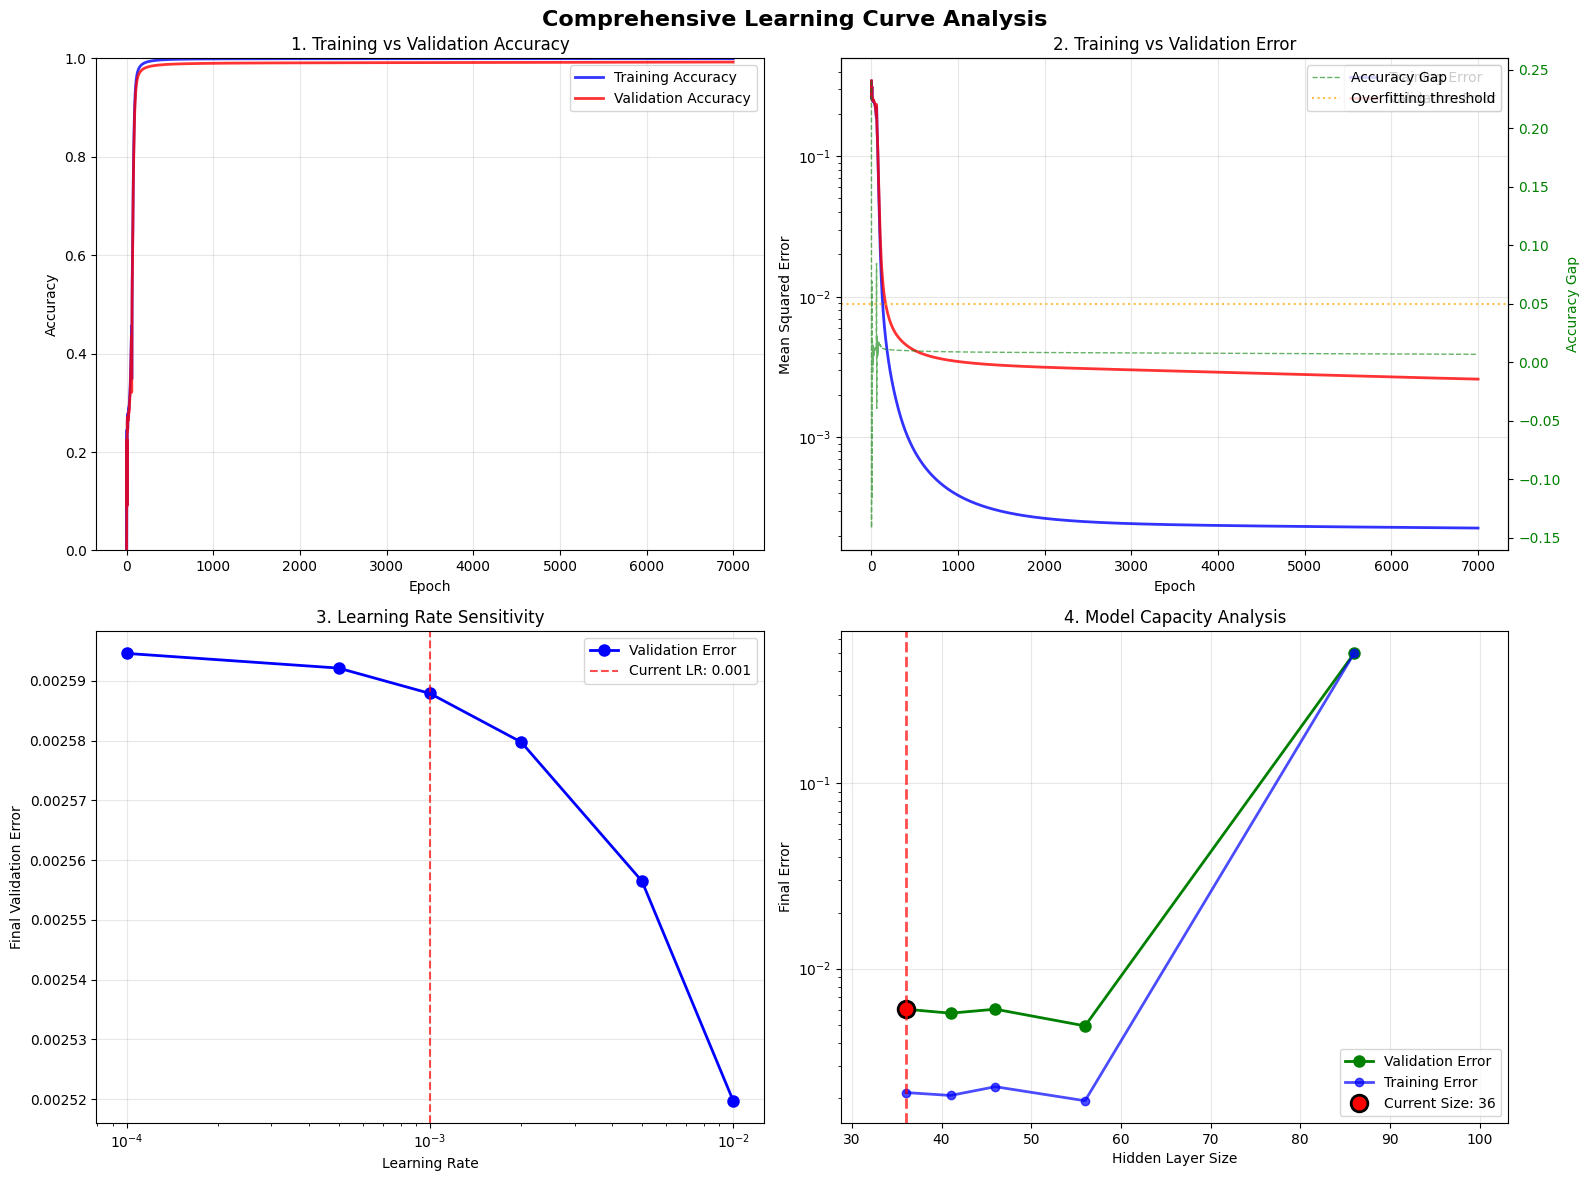

In [42]:
# ===============================================
# COMPREHENSIVE LEARNING CURVE ANALYSIS
# ===============================================
print("\nGenerating comprehensive learning curve analysis...")
# Use hidden sizes that are larger than input size to avoid dimension conflicts
appropriate_hidden_sizes = [input_size + 5, input_size + 10, input_size + 20, input_size + 50]
analysis_results = plot_comprehensive_learning_curves(
    train_errors, val_errors, nn, X_train, y_train, X_val, y_val,
    hidden_sizes=appropriate_hidden_sizes
)